# Feature set 1


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 40, 6, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 40, 6))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 240))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

#### Shapes of the data


In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 40, 6, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 40, 6, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 40, 6, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 40, 6, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 40, 6, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 40, 6, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 40, 6, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 40, 6, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 40, 6, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 40, 6, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 40, 6)
Y_data 1 = (873, 1)
X_data 2 = (888, 40, 6)
Y_data 2 = (888, 1)
X_data 3 = (925, 40, 6)
Y_data 3 = (925, 1)
X_data 4 = (990, 40, 6)
Y_data 4 = (990, 1)
X_data 5 = (936, 40, 6)
Y_data 5 = (936, 1)
X_data 6 = (823, 40, 6)
Y_data 6 = (823, 1)
X_data 7 = (838, 40, 6)
Y_data 7 = (838, 1)
X_data 8 = (806, 40, 6)
Y_data 8 = (806, 1)
X_data 9 = (816, 40, 6)
Y_data 9 = (816, 1)
X_data 10 = (837, 40, 6)
Y_data 10 = (837, 1)


## Defining Functions

## Simple nn models as function

In [10]:
def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['acc']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['acc']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_acc']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [28]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['acc']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['acc']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_acc']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph plotting function

In [12]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Val_Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table making function

In [13]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [14]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion Matrix function 

In [15]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [16]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

# Models

## Model 1

In [18]:
model=Sequential()
model.add(Flatten(input_shape=[40, 6]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [19]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6) (7859, 1) (873, 40, 6) (873, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Accuracy of Fold 1 is 0.5674335196505431
Time to train Fold 1 : 64.9732 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6) (7844, 1) (888, 40, 6) (888, 1)
Accuracy of Fold 2 is 0.8319760278950901
Time to train Fold 2 : 61.5973 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6) (7807, 1) (925, 40, 6) (925, 1)
Accuracy of Fold 3 is 0.8757243425077735
Time to train Fold 3 : 60.7191 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6) (7742, 1) (990, 40, 6) (990, 1)
Accuracy of Fold 4 is 0.8934590458423399
Time to train Fold 4 : 60.5616 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6) (7796, 1) (936, 40, 6) (936, 1)
Accuracy of Fold 5 is 0.9008004013711576
Time to train Fold 5 : 60.8785 seconds.

Fold #6
- - - - -

In [20]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5085648969788858, 0.5491151585197652, 0.5120274914089347, 0.5120274914089347
2, 0.7332396682042328, 0.7782727217667472, 0.7184684684684685, 0.7184684684684685
3, 0.7660252088246357, 0.799925636108843, 0.76, 0.76
4, 0.8062690999663884, 0.8261043200364924, 0.8010101010101011, 0.8010101010101011
5, 0.874965836061704, 0.8905672128829761, 0.8717948717948718, 0.8717948717948718
6, 0.8418706506610609, 0.8638246568343296, 0.8371810449574727, 0.8371810449574727
7, 0.8557987200406754, 0.8735060485705379, 0.850835322195704, 0.850835322195704
8, 0.8521934198597447, 0.8913280761398414, 0.8374689826302729, 0.8374689826302729
9, 0.8515655815828458, 0.9040973827967463, 0.8357843137254902, 0.8357843137254902
10, 0.8938666752450625, 0.9086731022363431, 0.8924731182795699, 0.8924731182795699


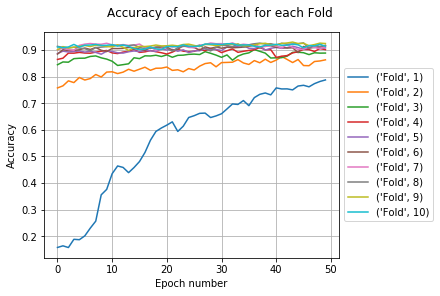

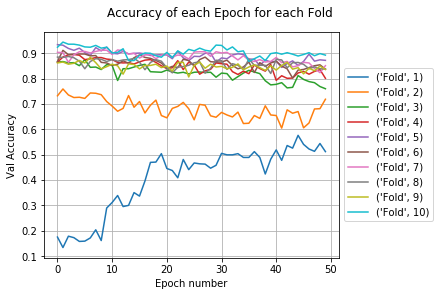

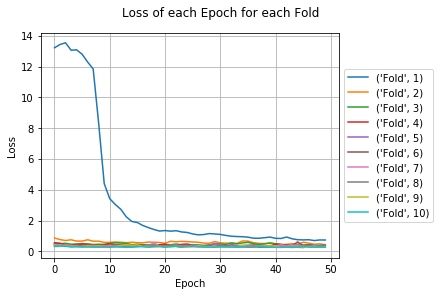

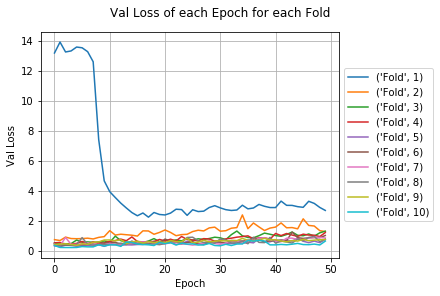

In [21]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array)

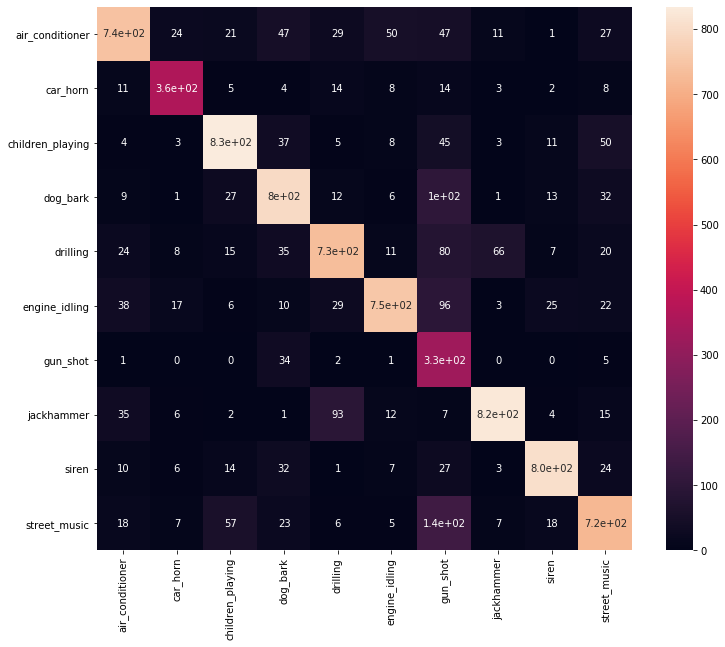

In [22]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [23]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.567434     64.9732
1    2  0.831976     61.5973
2    3  0.875724     60.7191
3    4  0.893459     60.5616
4    5  0.900800     60.8785
5    6  0.906979     61.9634
6    7  0.914832     61.7553
7    8  0.913835     62.6737
8    9  0.917456     62.2315
9   10  0.915612     62.5575

    Average Accuracy  Total Time
0          0.863811    619.9111


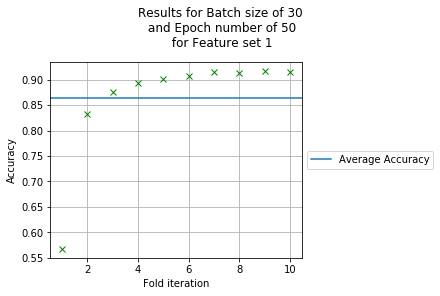

In [24]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

#### Model 1 with no cross validation

In [25]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 1s 162us/step - loss: 0.2746 - acc: 0.9212 - val_loss: 0.3662 - val_acc: 0.9140
Epoch 2/30
7895/7895 [==============================] - 1s 164us/step - loss: 0.3722 - acc: 0.9075 - val_loss: 0.7526 - val_acc: 0.8746
Epoch 3/30
7895/7895 [==============================] - 1s 162us/step - loss: 0.2937 - acc: 0.9131 - val_loss: 0.4717 - val_acc: 0.9008
Epoch 4/30
7895/7895 [==============================] - 1s 164us/step - loss: 0.2636 - acc: 0.9232 - val_loss: 0.4919 - val_acc: 0.8865
Epoch 5/30
7895/7895 [==============================] - 1s 165us/step - loss: 0.2723 - acc: 0.9241 - val_loss: 0.4996 - val_acc: 0.9008
Epoch 6/30
7895/7895 [==============================] - 1s 163us/step - loss: 0.2986 - acc: 0.9234 - val_loss: 0.4065 - val_acc: 0.9176
Epoch 7/30
7895/7895 [==============================] - 1s 163us/step - loss: 0.2637 - acc: 0.9256 - val_loss: 0.3743 - val_acc: 0.9008
E

# Model 2

In [29]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(40,6,1)))
model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)
Accuracy of Fold 1 is 0.8782123638926459
Time to train Fold 1 : 94.6499 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.9459834418213996
Time to train Fold 2 : 51.1379 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.9564192014352974
Time to train Fold 3 : 49.79 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.9555366449979088
Time to train Fold 4 : 47.9355 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.9605638218808831
Time to train Fold 5 : 51.1156 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (823,

In [31]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.564629392520055, 0.5745878248561518, 0.5773195876288659, 0.5773195876288659
1, 0.899821537183107, 0.9073260557005665, 0.8997747747747747, 0.8997747747747747
2, 0.8824995741015531, 0.8854530025307585, 0.8832432432432432, 0.8832432432432432
3, 0.894814731778033, 0.9027733829764013, 0.895959595959596, 0.895959595959596
4, 0.8884262758141447, 0.8953881224663158, 0.8888888888888888, 0.8888888888888888
5, 0.9054834898252301, 0.9108557770629647, 0.905224787363305, 0.905224787363305
6, 0.9199826064646462, 0.9286295447425814, 0.9212410501193318, 0.9212410501193318
7, 0.8609573686623244, 0.8659078043135636, 0.8610421836228288, 0.8610421836228288
8, 0.918668457744778, 0.9228837002091039, 0.9191176470588235, 0.9191176470588235
9, 0.9649895597864356, 0.9664692594722396, 0.965352449223417, 0.965352449223417


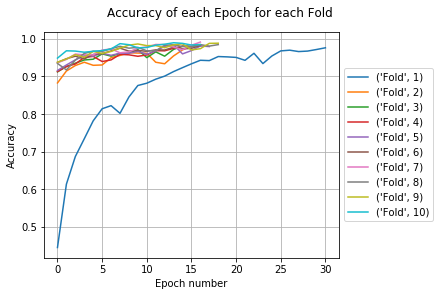

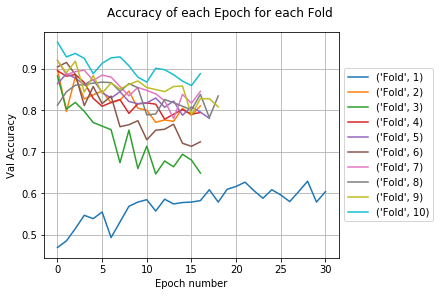

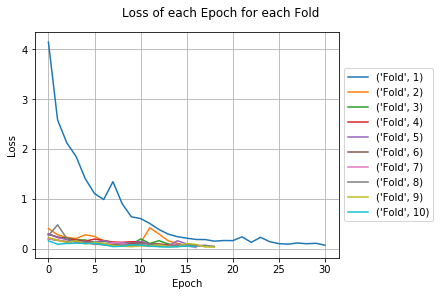

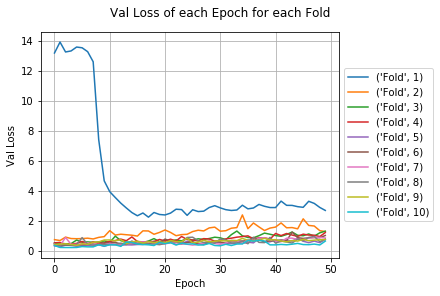

In [32]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2) 

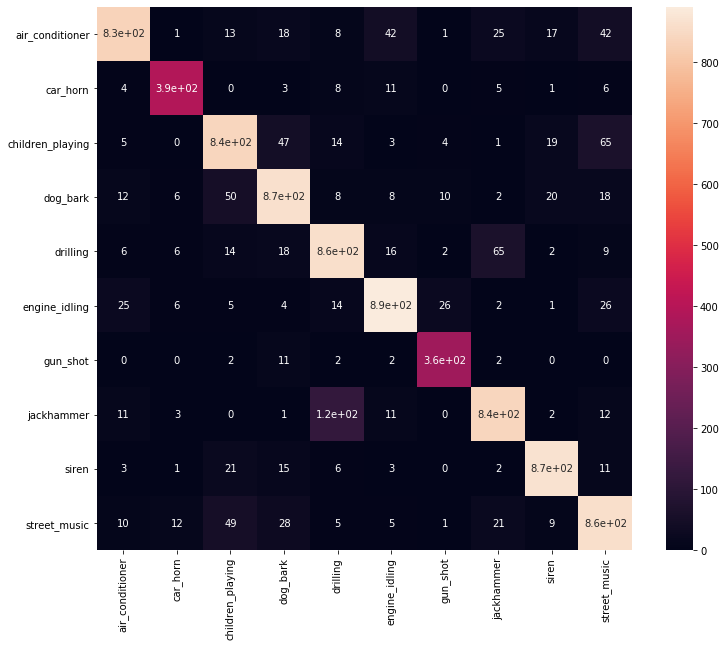

In [33]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [34]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.878212     94.6499
1    2  0.945983     51.1379
2    3  0.956419     49.7900
3    4  0.955537     47.9355
4    5  0.960564     51.1156
5    6  0.964776     48.8396
6    7  0.969202     48.9121
7    8  0.968963     54.8175
8    9  0.971909     54.9487
9   10  0.976418     49.0669

    Average Accuracy  Total Time
0          0.954798    551.2137


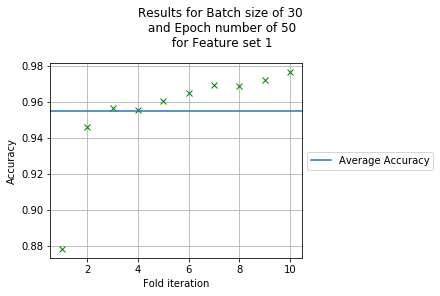

In [35]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 with no cross validation

In [36]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 40, 6,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 3s 372us/step - loss: 0.1153 - acc: 0.9644 - val_loss: 0.2030 - val_acc: 0.9295
Epoch 2/30
7895/7895 [==============================] - 3s 388us/step - loss: 0.1515 - acc: 0.9528 - val_loss: 0.3286 - val_acc: 0.9056
Epoch 3/30
7895/7895 [==============================] - 3s 392us/step - loss: 0.1230 - acc: 0.9625 - val_loss: 0.2070 - val_acc: 0.9307
Epoch 4/30
7895/7895 [==============================] - 3s 393us/step - loss: 0.1486 - acc: 0.9631 - val_loss: 0.3661 - val_acc: 0.9032
Epoch 5/30
7895/7895 [==============================] - 3s 393us/step - loss: 0.0861 - acc: 0.9733 - val_loss: 0.2761 - val_acc: 0.9008
Epoch 6/30
7895/7895 [==============================] - 3s 391us/step - loss: 0.0614 - acc: 0.9807 - val_loss: 0.3960 - val_acc: 0.8937
Epoch 7/30
7895/7895 [==============================] - 3s 392us/step - loss: 0.0603 - acc: 0.9833 - val_loss: 0.3869 - val_acc: 0.9032
E

## Model 3

In [37]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [38]:
Accuracy_array_3=[]
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)
Accuracy of Fold 1 is 0.5688959776484945
Time to train Fold 1 : 184.2834 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.7087884806355512
Time to train Fold 2 : 79.1582 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.7110285640894433
Time to train Fold 3 : 79.6507 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.7203277935869246
Time to train Fold 4 : 75.2514 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.729704691863075
Time to train Fold 5 : 75.8133 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (82

In [39]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.49711748085936525, 0.5363502395518314, 0.4868270332187858, 0.4868270332187858
2, 0.736323046816176, 0.8058073417291572, 0.7094594594594594, 0.7094594594594594
3, 0.7211329715041985, 0.772742638686851, 0.7005405405405405, 0.7005405405405405
4, 0.7850056581665503, 0.8191721010496446, 0.7757575757575758, 0.7757575757575758
5, 0.7728019039811239, 0.8158661816102328, 0.7521367521367521, 0.7521367521367521
6, 0.7252406843809325, 0.7610474126736267, 0.7095990279465371, 0.7095990279465371
7, 0.7759518840769911, 0.8074566377231528, 0.766109785202864, 0.766109785202864
8, 0.7691387562436895, 0.8256525258859261, 0.7431761786600496, 0.7431761786600496
9, 0.7515189855127503, 0.8227347637178638, 0.7316176470588235, 0.7316176470588235
10, 0.8383844820119175, 0.8545973961612676, 0.8339307048984468, 0.8339307048984468


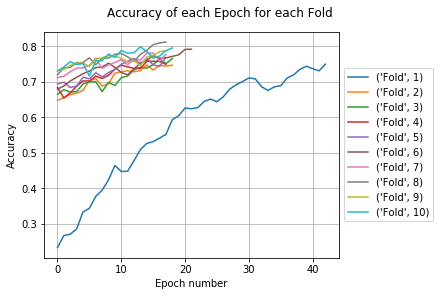

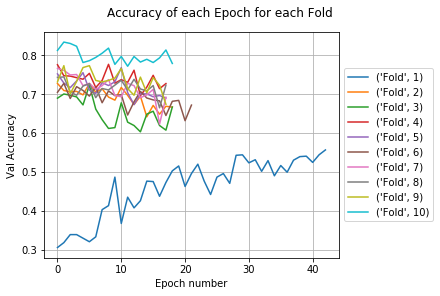

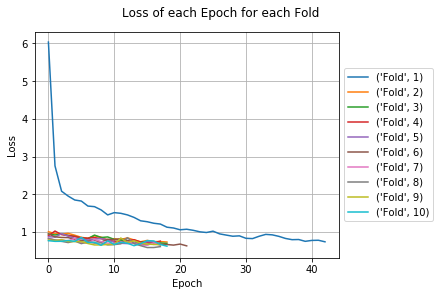

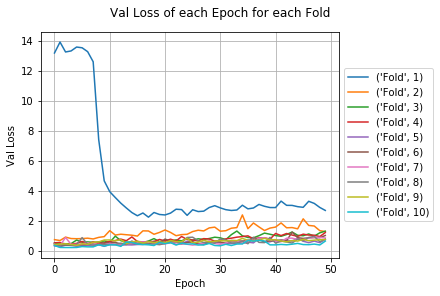

In [40]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3) 

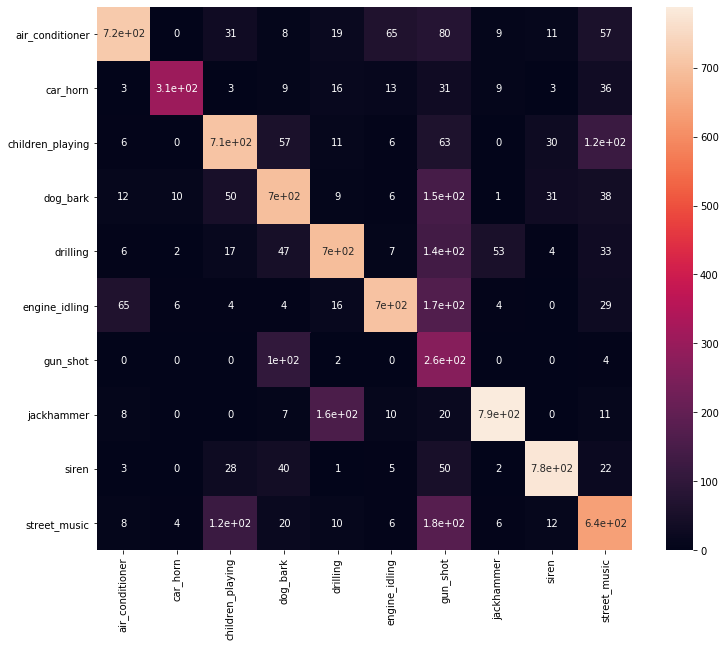

In [41]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [42]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.568896    184.2834
1    2  0.708788     79.1582
2    3  0.711029     79.6507
3    4  0.720328     75.2514
4    5  0.729705     75.8133
5    6  0.742819     93.8648
6    7  0.751084     76.7294
7    8  0.768462     77.3546
8    9  0.760204     77.2960
9   10  0.766581     81.6329

    Average Accuracy  Total Time
0           0.72279    901.0347


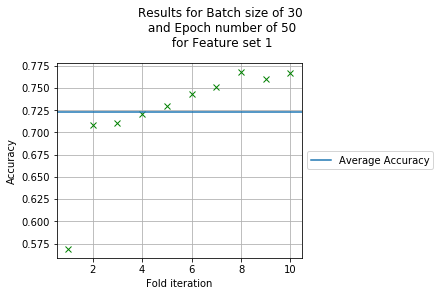

In [43]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

In [44]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 5s 573us/step - loss: 0.7486 - acc: 0.7469 - val_loss: 0.4530 - val_acc: 0.8124
Epoch 2/30
7895/7895 [==============================] - 5s 572us/step - loss: 0.6946 - acc: 0.7619 - val_loss: 0.5288 - val_acc: 0.8196
Epoch 3/30
7895/7895 [==============================] - 5s 573us/step - loss: 0.6957 - acc: 0.7611 - val_loss: 0.4990 - val_acc: 0.8423
Epoch 4/30
7895/7895 [==============================] - 5s 574us/step - loss: 0.6798 - acc: 0.7662 - val_loss: 0.6370 - val_acc: 0.7838
Epoch 5/30
7895/7895 [==============================] - 5s 574us/step - loss: 0.7315 - acc: 0.7425 - val_loss: 0.5585 - val_acc: 0.8196
Epoch 6/30
7895/7895 [==============================] - 5s 573us/step - loss: 0.6962 - acc: 0.7616 - val_loss: 0.6030 - val_acc: 0.8065
Epoch 7/30
7895/7895 [==============================] - 5s 572us/step - loss: 0.6513 - acc: 0.7795 - val_loss: 0.5950 - val_acc: 0.8088
E

## Model 4

In [45]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(40,6,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [46]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 40, 6, 1) (7859, 10) (873, 40, 6, 1) (873, 10)


/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.6421903148361853
Time to train Fold 1 : 94.6348 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 40, 6, 1) (7844, 10) (888, 40, 6, 1) (888, 10)
Accuracy of Fold 2 is 0.7070029027576197
Time to train Fold 2 : 63.3003 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 40, 6, 1) (7807, 10) (925, 40, 6, 1) (925, 10)
Accuracy of Fold 3 is 0.7174330728485292
Time to train Fold 3 : 43.5421 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 40, 6, 1) (7742, 10) (990, 40, 6, 1) (990, 10)
Accuracy of Fold 4 is 0.7237206735664379
Time to train Fold 4 : 53.1365 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 40, 6, 1) (7796, 10) (936, 40, 6, 1) (936, 10)
Accuracy of Fold 5 is 0.7191355762359594
Time to train Fold 5 : 51.0383 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 40, 6, 1) (7909, 10) (823, 40, 6, 1) (823, 10)
Accuracy of Fold 6 is 0.734732583141513
Time to train Fold 6 : 43.8616 seconds.


In [47]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.4531985465907138, 0.47412152731916213, 0.4925544100801833, 0.4925544100801833
2, 0.5910212190830032, 0.5621509362308287, 0.6497747747747747, 0.6497747747747747
3, 0.6622698918212836, 0.633721177369239, 0.7124324324324325, 0.7124324324324325
4, 0.6868071428182085, 0.6647946288838846, 0.7343434343434343, 0.7343434343434343
5, 0.6635840681679392, 0.6295667925181471, 0.7158119658119658, 0.7158119658119658
6, 0.6503395037193925, 0.6059472202142117, 0.7120291616038882, 0.7120291616038882
7, 0.6210271040672327, 0.5893021463670869, 0.6789976133651552, 0.6789976133651552
8, 0.6308847074785158, 0.6008218027048904, 0.6910669975186104, 0.6910669975186104
9, 0.616502960667517, 0.6080174479518999, 0.6801470588235294, 0.6801470588235294
10, 0.6901482883629364, 0.6476020380877274, 0.7502986857825568, 0.7502986857825568


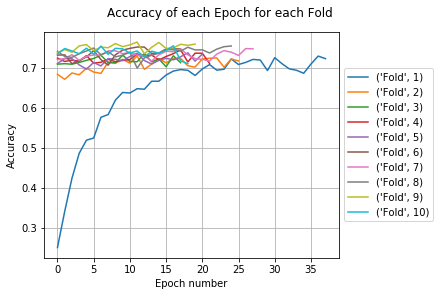

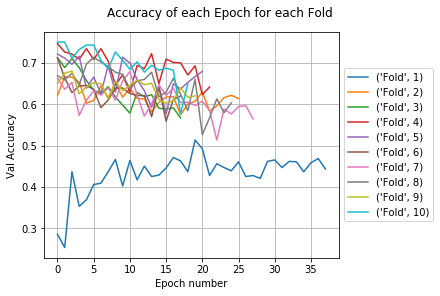

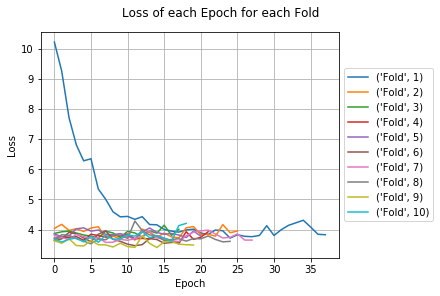

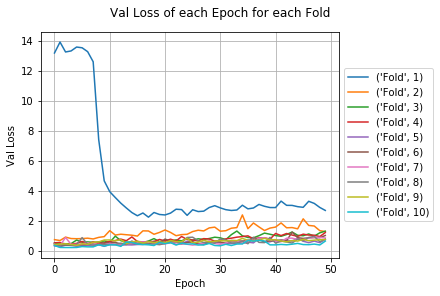

In [48]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4) 

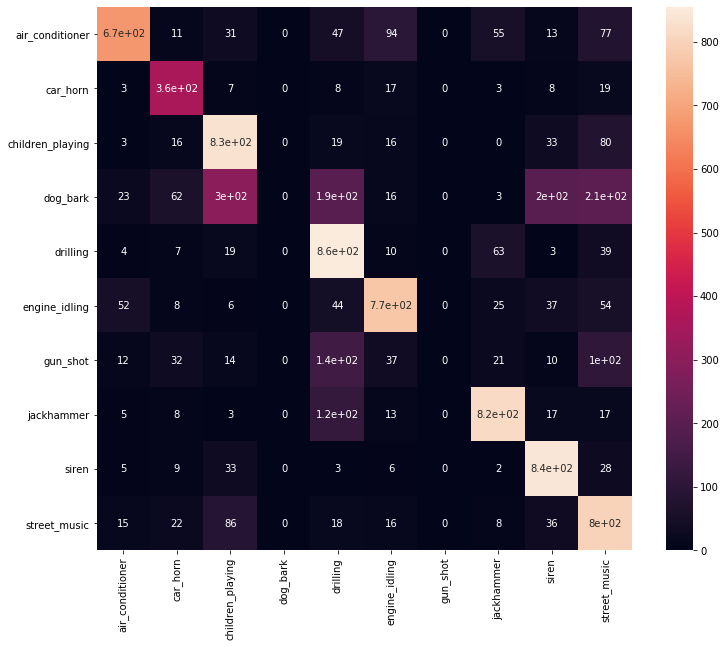

In [49]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [50]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.642190     94.6348
1    2  0.707003     63.3003
2    3  0.717433     43.5421
3    4  0.723721     53.1365
4    5  0.719136     51.0383
5    6  0.734733     43.8616
6    7  0.732491     68.5366
7    8  0.737573     61.3412
8    9  0.751453     49.1061
9   10  0.738402     46.6122

    Average Accuracy  Total Time
0          0.720413    575.1097


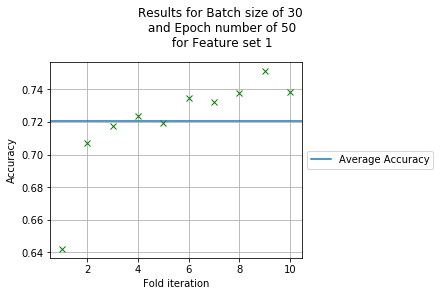

In [51]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [52]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - 3s 340us/step - loss: 3.7096 - acc: 0.7357 - val_loss: 3.5411 - val_acc: 0.7491
Epoch 2/30
7895/7895 [==============================] - 3s 341us/step - loss: 3.9346 - acc: 0.7218 - val_loss: 4.6317 - val_acc: 0.6583
Epoch 3/30
7895/7895 [==============================] - 3s 341us/step - loss: 3.9727 - acc: 0.7224 - val_loss: 3.7312 - val_acc: 0.7216
Epoch 4/30
7895/7895 [==============================] - 3s 342us/step - loss: 3.6287 - acc: 0.7476 - val_loss: 3.6025 - val_acc: 0.7360
Epoch 5/30
7895/7895 [==============================] - 3s 341us/step - loss: 3.7397 - acc: 0.7398 - val_loss: 3.8831 - val_acc: 0.7216
Epoch 6/30
7895/7895 [==============================] - 3s 341us/step - loss: 3.7652 - acc: 0.7353 - val_loss: 4.1251 - val_acc: 0.7049
Epoch 7/30
7895/7895 [==============================] - 3s 342us/step - loss: 3.6670 - acc: 0.7431 - val_loss: 3.6470 - val_acc: 0.7395
E

## Model Comparisson

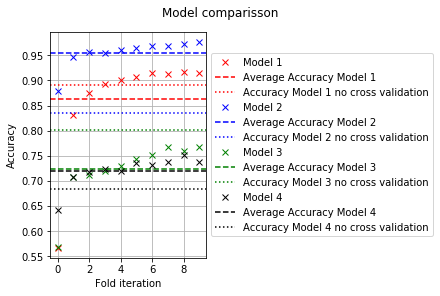

In [56]:
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

ax1.plot(Fold_accuracy_4,"kx",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='k',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='k',ls=":")

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Logistic regression results

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of logistic regression classifier on test set: 0.49


/Users/sokratismourselas/opt/anaconda3/envs/r_env/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


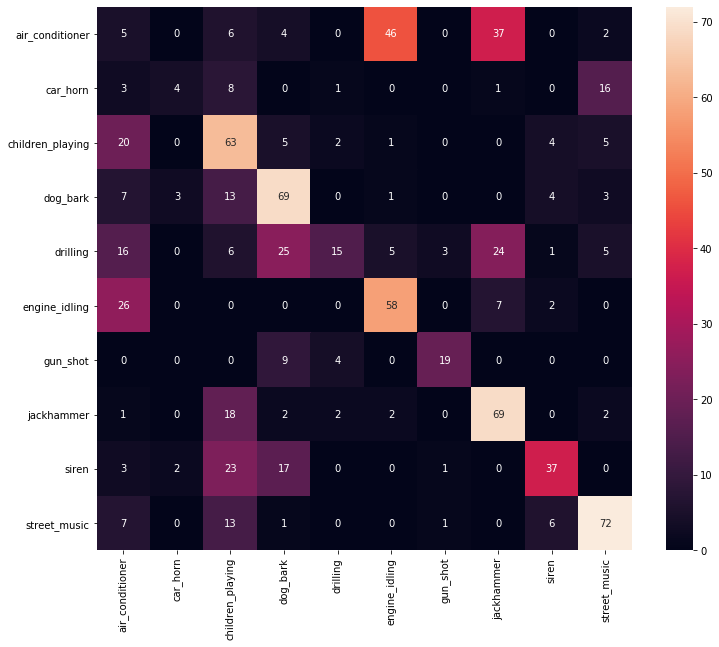

In [55]:
Confusion_matrix(X_test, y_test, model=logreg)